In [1]:
import torch
from botorch.optim import optimize_acqf
from matplotlib import pyplot as plt

from acquisition import ExpectedInformationGain
from algorithms import GridOpt

from utils import build_parabolic_target_func, unif_random_sample_domain, fit_gp_model

torch.cuda.is_available()

True

# Settings

In [2]:
random_seed = 141

ndim = 1 #target function dimensionality

domain = torch.tensor([[-2,2]]).double().repeat(ndim,1) #the acquisition domain, must have shape = (ndim, 2)
                                                        #where domain[i,0] and domain[i,1] represent
                                                        #the lower and upper bounds of the ith input dimension
                                                        #(these same bounds will be applied to the sampled execution paths)
        
x_star = torch.tensor([0.5]).double().repeat(ndim) #the input that maximizes the parabolic target function (should be within domain)
                                          #must have length = ndim
    
n_obs_init = 3 #number of random observations on which to initialize model


n_iter = 3 #number of optimization iterations to perform


n_steps_acq_grid = 1000 #number of steps per dimension in the acquisition function grid-scan



n_samples = 1000 #number of posterior samples on which to evaluate execution paths

n_steps_sample_grid = 100 #number of steps per dimension in the posterior sample grid scans 

algo = GridOpt(domain=domain, n_samples=n_samples, n_steps_sample_grid=n_steps_sample_grid)



# Initialize

In [3]:
torch.manual_seed(random_seed)

#build ndim dimensional parabolic target function
target_func = build_parabolic_target_func(x_star)

#Observe target function n_obs_init times using a uniform sample of the domain
x_obs = unif_random_sample_domain(n_samples = n_obs_init, domain = domain)
y_obs = target_func(x_obs) 

#fit model on initial observations
model = fit_gp_model(x_obs, y_obs)

#initialize dictionary for storing relevant results from each iteration
iter_data = {}

In [4]:

myEIG = ExpectedInformationGain(model = model, algo = algo)
new_point_analytic, _ = optimize_acqf(
    acq_function=myEIG,
    bounds=domain.T,
    q=1,
    num_restarts=20,
    raw_samples=20,
    options={},
)

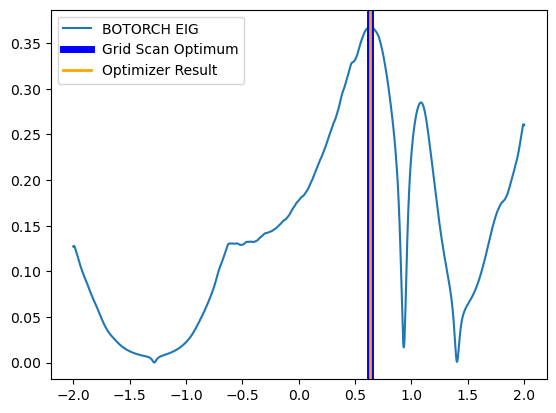

In [5]:
fig, ax = plt.subplots()

X = torch.linspace(-2,2,1000).double()
eig = myEIG(X.reshape(1000,1,1))
ax.plot(X,eig.detach().numpy(), label='BOTORCH EIG')
ax.axvline(X[torch.argmax(eig)], c='b', lw=5, label='Grid Scan Optimum')
ax.axvline(new_point_analytic.squeeze(), c='orange', lw=2, label='Optimizer Result')
ax.legend()

In [6]:
new_point_analytic

tensor([[0.6296]], dtype=torch.float64)